In [1]:
"""
Created on Friday 12th March 2021
@author: Aditya Asopa, Bhalla Lab, NCBS
"""
## Import libraries
import sys
import os
import importlib
import pathlib
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from scipy.optimize  import curve_fit
from scipy.signal import find_peaks, peak_widths

from eidynamics import ephys_classes
from eidynamics import ephys_functions
from eidynamics import abf_to_data
from eidynamics import plot_tools, utils
from eidynamics import pattern_index
from eidynamics.errors      import *

%matplotlib widget

In [13]:
df = pd.read_hdf(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_LTMRand_CC_long.h5")

In [14]:
df.iloc[:, :20].sample(10)

,cellID,sex,ageAtInj,ageAtExpt,incubation,unit,location,protocol,exptSeq,exptID,sweep,stimFreq,numSq,intensity,pulseWidth,clampMode,clampPotential,condition,AP,IR
443,3201,F,26 days,78 days,52 days,mV,CA1,LTMRand,3,4,12,40,7,100,2,CC,-70,Control,0,106.633553
476,3192,F,26 days,72 days,46 days,mV,CA1,LTMRand,0,8,21,20,15,100,2,CC,-70,Control,1,170.506271
58,5211,M,31 days,63 days,32 days,mV,CA1,LTMRand,7,14,11,30,7,100,2,CC,-70,Control,0,81.095985
517,3192,F,26 days,72 days,46 days,mV,CA1,LTMRand,2,10,14,30,7,100,2,CC,-70,Control,0,151.660278
382,3201,F,26 days,78 days,52 days,mV,CA1,LTMRand,0,0,23,20,15,100,2,CC,-70,Control,0,754.317444
204,3401,F,28 days,72 days,44 days,mV,CA1,LTMRand,0,5,13,20,7,100,2,CC,-70,Control,0,172.370026
27,5211,M,31 days,63 days,32 days,mV,CA1,LTMRand,6,13,4,50,7,100,2,CC,-70,Control,0,90.354385
95,3781,M,45 days,96 days,51 days,mV,CA1,LTMRand,5,9,24,20,15,100,2,CC,-70,Control,0,122.493217
519,3192,F,26 days,72 days,46 days,mV,CA1,LTMRand,2,10,16,30,15,100,2,CC,-70,Control,1,148.431259
474,3192,F,26 days,72 days,46 days,mV,CA1,LTMRand,0,8,19,20,15,100,2,CC,-70,Control,1,178.432846


In [33]:
## CA3 grid heatmap
filepath = r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\23-12-25_GrikAA402\4021\expt003.txt"
data = pd.read_csv(filepath, sep = '\t')


In [37]:
# average across coord column
data_avg = data.groupby(['patternID']).mean().reset_index()
data_avg.head()
data2 = data[data['patternID'] <51]

In [35]:
importlib.reload(plot_tools)

<module 'eidynamics.plot_tools' from 'c:\\Users\\adity\\OneDrive\\NCBS\\Lab\\Projects\\EI_Dynamics\\Analysis\\eidynamics\\plot_tools.py'>

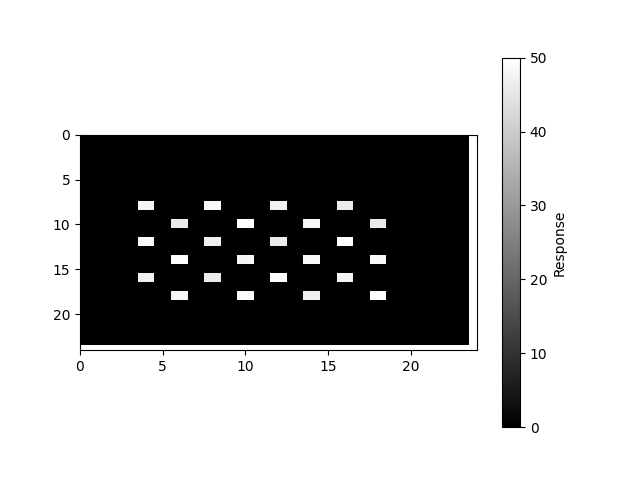

In [39]:
# plot heatmap on a grid using plot_tools.plot_grid()
fig, ax = plt.subplots(1, 1, )
_,_,ax=plot_tools.plot_grid(spot_locs=data2['patternID'].to_numpy(), spot_values=data2['patternID'].to_numpy(), ax=ax, locs_is_patternID=True)


In [2]:
inputABFfile1 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Tools\Optics\OPT101_timelag_test\2024_06_12_0012.abf")
inputABFfile2 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Tools\Optics\OPT101_timelag_test\2024_06_12_0015.abf")

In [3]:
data_exttrig = abf_to_data.abf_to_data(inputABFfile1, exclude_channels=[3], baseline_subtraction=True,
                signal_scaling=1, sampling_freq=2e4, filter_type='', filter_cutoff=1000,
                data_order="channelwise", plot_data=False)
data_follower = abf_to_data.abf_to_data(inputABFfile2, exclude_channels=[3], baseline_subtraction=True,
                signal_scaling=1, sampling_freq=2e4, filter_type='', filter_cutoff=1000,
                data_order="channelwise", plot_data=False)

Loading ABF file
Datafile has 500 sweeps in 3 channels.
Loading ABF file
Datafile has 500 sweeps in 3 channels.


50 500 12 125 2488 2625 137


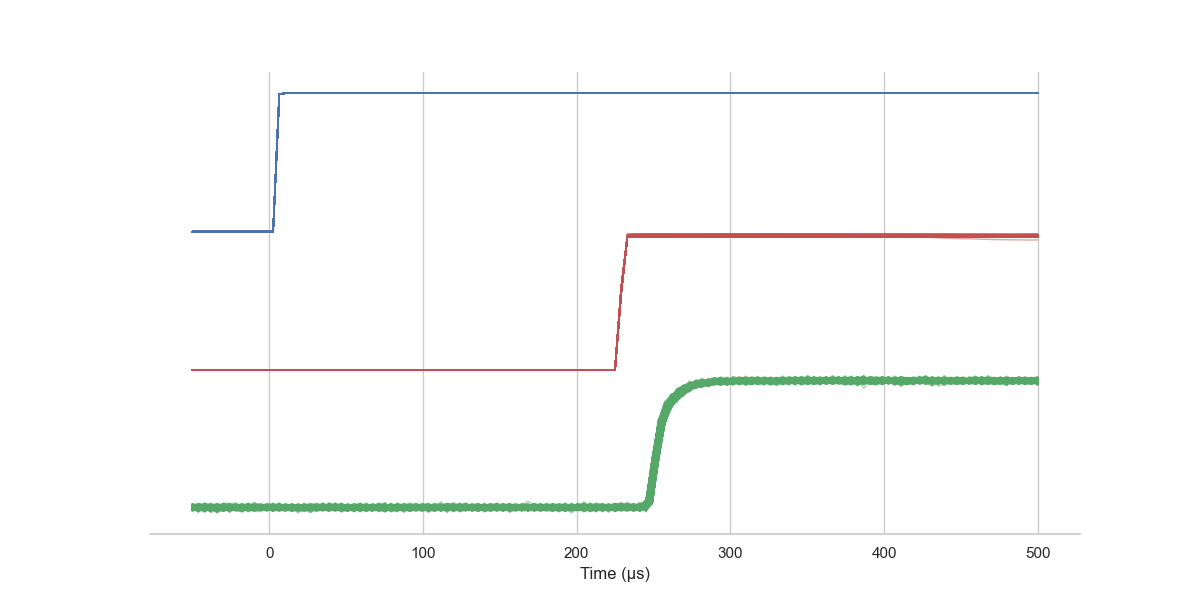

In [73]:
plt.close('all')
import seaborn as sns
# seborn set theme to be paper
sns.set_theme(style="whitegrid")
# set the figure size
# plt.figure(figsize=(12, 6))

t1, t2 = 50,500
Fs = 0.25
n1,n2 = int(t1*Fs), int(t2*Fs)
ori = 10

y1 = int(Fs*(ori*1000) - n1 )
y2 = int(Fs*(ori*1000) + n2 )

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

print(t1, t2, n1,n2, y1, y2, y2-y1)
ax.plot(np.linspace( -t1, t2, n2+n1 ), 2+ data_exttrig[0][0][:,y1:y2].T / 4000, 'b', alpha=0.5,  linewidth=1)
ax.plot(np.linspace( -t1, t2, n2+n1 ), 1+ data_exttrig[0][1][:,y1:y2].T / 0.08, 'r', alpha=0.5, linewidth=1)
ax.plot(np.linspace( -t1, t2, n2+n1 ), 0+ data_exttrig[0][2][:,y1:y2].T / 0.004, 'g', alpha=0.5, linewidth=1)
# x and y labels
ax.set_xlabel('Time (µs)')
# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# remove ticks and tick labels from y axis
ax.yaxis.set_ticks([])

# save as svg
plt.savefig(r'C:\Users\adity\OneDrive\NCBS\Lab\Thesis\Images\OPT101_trigger_delay.svg', format='svg', dpi=300)

In [90]:
cmd = data_exttrig[0][0].T
framettl = data_exttrig[0][1].T
led = data_exttrig[0][2].T

In [91]:
# scale each trial for each channel between 1 and 0
cmd = (cmd - cmd.min(axis=0)) / (cmd.max(axis=0) - cmd.min(axis=0))
framettl = (framettl - framettl.min(axis=0)) / (framettl.max(axis=0) - framettl.min(axis=0))
led = (led - led.min(axis=0)) / (led.max(axis=0) - led.min(axis=0))

# digitize the signals, threshold = 0.1
cmd = cmd > 0.2
framettl = framettl > 0.1
led = led > 0.1

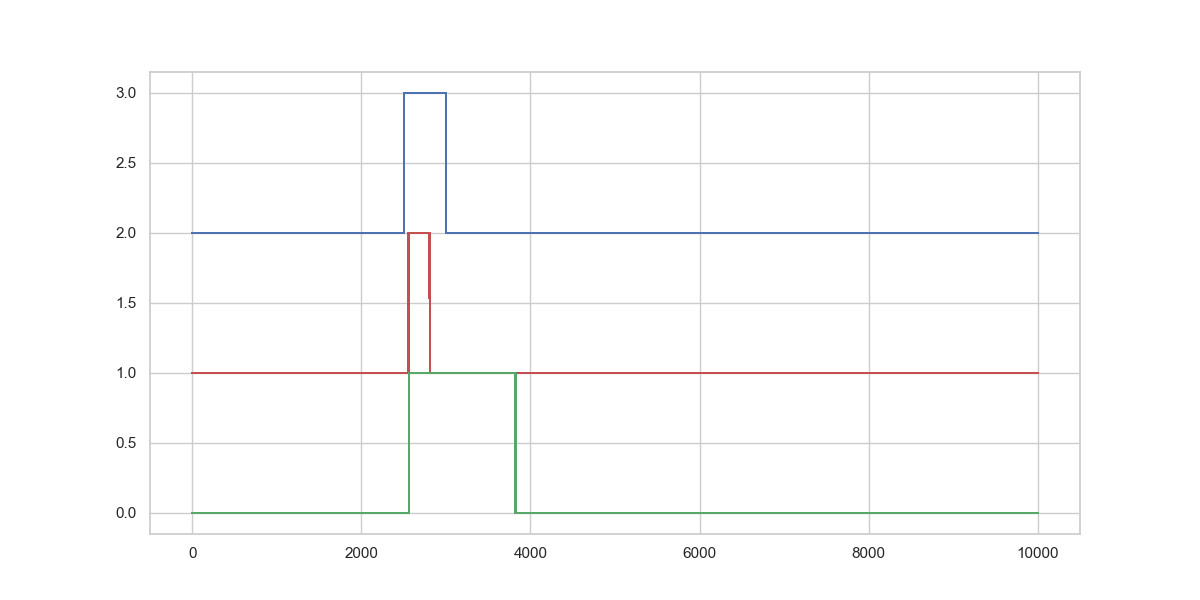

In [92]:
# plot the digitized signals
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(2+ cmd, 'b', alpha=0.5,  linewidth=1)
ax.plot(1+ framettl, 'r', alpha=0.5, linewidth=1)
ax.plot(0+ led, 'g', alpha=0.5, linewidth=1)

In [99]:
# get the indices of the first value above zero for each trial for each channel
cmd_idx = np.argmax(cmd, axis=0)
framettl_idx = np.argmax(framettl, axis=0)
led_idx = np.argmax(led, axis=0)

In [100]:
delay1 = 4*(framettl_idx - cmd_idx)
delay2 = 4*(led_idx - framettl_idx)

In [101]:
# get mean and std of cmd_idx, delay1, delay2
print(f"cmd_idx: {cmd_idx.mean()} ± {cmd_idx.std()}")
print(f"delay1: {delay1.mean()} ± {delay1.std()}")
print(f"delay2: {delay2.mean()} ± {delay2.std()}")

cmd_idx: 2502.0 ± 0.0
delay1: 220.0 ± 0.0
delay2: 20.888 ± 1.700428181370798


### Raw data from abf files for testing

In [2]:
inputABFfileE = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\screened_cells\23-12-28_GrikAA404\4041\2023_12_28_0007_rec.abf")
# inputABFfileI = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\22-04-18_G749\7492\2022_04_18_0023_rec.abf")
coordpath = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\polygonProtocols\3_210331_24hex_5-15sq_ExtFreq_3repeats_24frames.txt")


In [83]:
#load cell
cell = ephys_classes.Neuron.loadCell(r"C:\Users\adity\OneDrive\NCBS\Lab\\Projects\\EI_Dynamics\\Data\\screened_cells\\21-03-04_G233\\2331\\\2331.pkl")

Cell object loaded from file:  C:\Users\adity\OneDrive\NCBS\Lab\\Projects\\EI_Dynamics\\Data\\screened_cells\\21-03-04_G233\\2331\\\2331.pkl


In [84]:
data = cell.data['FreqSweep']

In [86]:
data.iloc[0,:40]

cellID                                                           2331
sex                                                                 F
ageAtInj                                             31 days 00:00:00
ageAtExpt                                            88 days 00:00:00
incubation                                           57 days 00:00:00
unit                                                               mV
location                                                          CA1
protocol                                                    FreqSweep
exptSeq                                                             0
exptID                                                              2
sweep                                                               1
stimFreq                                                           20
numSq                                                               1
intensity                                                         100
pulseWidth          

1941
F
36 days 00:00:00
78 days 00:00:00
42 days 00:00:00
mV
CA1
FreqSweep
0
2
1
20
5
100
2
CC
-70
Control
True
0.7350090891122818
0.046219112475498904
-70.7550048828125
1
48
8
0.5
0.2
3004


In [79]:
np.concatenate([np.array([4481]),(20000*utils.get_pulse_times(8,4481/20000,20)).astype(int)])

array([ 4481,  4481,  5481, ...,  9481, 10481, 11481])

In [39]:
expt7 = data[data['exptID']==6]
Fs = 2e4
row = expt7.iloc[1700, :]
ipi = int(Fs / row['stimFreq'])
pw  = int(Fs * row['pulseWidth'] / 1000)
protocol = row['protocol']
numPulses = row['numPulses'] 

In [40]:
sweep = row.iloc[36:]
[cell, framettl, led, field] = np.reshape(sweep, (4, -1))

In [41]:
ipi

20000

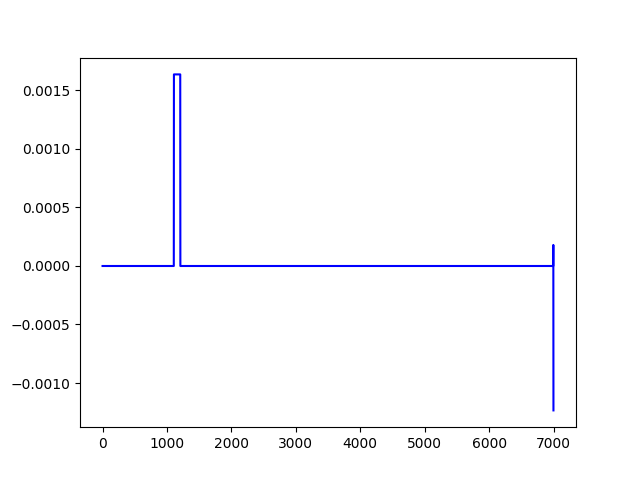

In [42]:
# make a figure
fig, ax = plt.subplots(1, 1)
ax.plot(led, 'b')

In [43]:
binled, locs = utils.binarize_trace(led)
# add binled to fig
ax.plot(binled, 'r')

In [47]:
#hdf file
hdffilepath = r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_SpikeTrain_CC_long.h5"
#open hdf file
data = pd.read_hdf(hdffilepath, key='data')

In [48]:
data['cellID'].unique()

array([4041, 4001], dtype=int64)

### Get the expected fits from Upi's code

In [ ]:
from eidynamics import fit_PSC # modified fit_PSC to return the fit parameters

In [ ]:
fits = fit_PSC.main(time[0,:20000],signalE[0,:20000], 20, show_plots=True, fig='', ax='')
fits[2][0].plot(time[0,:20000],signalE[0,:20000], 'g', alpha=0.5, label='recording')

In [ ]:
print(len(fits[0]['deconv']))

In [ ]:
for i,j  in enumerate(fits[0]['kfit']):
    if j < 0:
        print(i)
        break

In [ ]:
stim_times = [0.2, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
Fs = 2e4
delay = 242 # datapoints, 12.1 ms
kernel = fits[0]['kfit'][4242:]

expected_trace = np.zeros((40000,))
for i in stim_times:
    expected_trace[int((i*Fs)+delay):int((i*Fs)+delay)+len(kernel)] += kernel

observed_trace = np.zeros((40000,))
observed_trace[0:20000] = signalE[0,:20000]

fig2, ax2 = plt.subplots(1,3, figsize=(18, 4.8))
ax2[0].plot(observed_trace, 'g', alpha=0.5, label='observed - recorded data')
ax2[0].plot(expected_trace, linestyle=':',color='orange', label='expected_by_adding_kernels')
ax2[1].plot(expected_trace-observed_trace, 'orange', label='difference')

peaks_expected, _ = find_peaks(-1*expected_trace, height=80, distance=500, prominence=10)
peaks_observed, _ = find_peaks(-1*observed_trace, height=80, distance=500, prominence=10)

ax2[2].plot(range(9), expected_trace[peaks_expected] / expected_trace[peaks_expected[0]], 'orange', label='expected')
ax2[2].plot(range(9), observed_trace[peaks_observed] / observed_trace[peaks_observed[0]], 'g', label='observed' )
ax2[2].plot(range(9), np.concatenate([[1],fits[0]['deconv']/fits[0]['deconv'][0]]), 'b', label="Deconv" )
ax2[2].set_ylim([-1,3])
ax2[2].legend(loc='upper left')

In [ ]:
def get_signal_inflection_time(signal, peaks_to_detect='all', width=20, movavg_window=40, baseline_time_sec=0.2, stim_start_sec=0.2, Fs=2e4, filter_type='butter', filter_cutoff=2000, mode='test'):
    stim_start= int(Fs*stim_start_sec)
    # subtract baseline from the trace and filter the signal
    baseline = np.mean(signal[:int(Fs*baseline_time_sec)])
    trace  = signal - baseline
    if filter_type:
        trace  = filter_data(trace, filter_type=filter_type,high_cutoff=filter_cutoff,sampling_freq=Fs)
    
    # get the fluctuations in the signal
    moving_avg          = moving_average(np.append(trace,np.zeros(movavg_window-1)), movavg_window)
    fluctuations        = moving_avg - signal
    fluctuations = filter_data(fluctuations, filter_type=filter_type,high_cutoff=filter_cutoff,sampling_freq=Fs)
    stddev_fluctuations = np.std(fluctuations[:stim_start])
    fluctuations_above_stddev = np.sign(fluctuations - stddev_fluctuations)
    
    # peak detection is started from the signal start time i.e. t=0, therefore no need to add stim_start to inflection point calc
    _, peaks_properties = find_peaks(fluctuations_above_stddev, width=int(0.8*movavg_window)) #distance=100,
    
    if peaks_to_detect =='first':
        first_wide_fluctuation_above_std_dev   = peaks_properties['left_ips'][0]
        fluctuation_width    = peaks_properties['widths'][0]
    
        # inflection_point    = int(first_wide_fluctuation_above_std_dev) + w - fluctuation_width
        inflection_point      = int(first_wide_fluctuation_above_std_dev + width )
        inflection_point_sec  = (first_wide_fluctuation_above_std_dev + width )/Fs
        response_delay        = 1000*(inflection_point_sec - stim_start_sec)
        signal_value_at_inflection = signal[inflection_point]
    elif peaks_to_detect =='all':
        locs = peaks_properties['left_ips']
        inflection_point_sec = locs/Fs
        
        # inflection_point_sec = []
        # response_delay = []
        # signal_value_at_inflection = []
        # for i in range(len(peaks_properties['left_ips'])):
        #     first_wide_fluctuation_above_std_dev   = peaks_properties['left_ips'][i]
        #     fluctuation_width    = peaks_properties['widths'][i]
        
        #     # inflection_point    = int(first_wide_fluctuation_above_std_dev) + w - fluctuation_width
        #     inflection_point      = int(first_wide_fluctuation_above_std_dev + width )
        #     inflection_point_sec.append( (first_wide_fluctuation_above_std_dev + width )/Fs )
        #     response_delay.append( 1000*(inflection_point_sec[i] - stim_start_sec) )
        #     signal_value_at_inflection.append( signal[inflection_point] )
    
    if mode=='test':
        return inflection_point_sec, response_delay, signal_value_at_inflection, moving_avg, fluctuations, fluctuations_above_stddev, peaks_properties
    
    return inflection_point_sec, response_delay, signal_value_at_inflection

In [ ]:
trace = -1*signalE[13,:]
inflection_point_sec, response_delay, signal_value_at_inflection, moving_avg, fluctuations, fluctuations_above_stddev,peakprops = utils.get_signal_inflection_time(trace, width=40, movavg_window=240, mode='test')

In [ ]:
plt.subplots(figsize=(15,5))
plt.plot(time[0,:], trace)
plt.plot(time[0,:], moving_avg)
plt.plot(time[0,:], fluctuations)
plt.plot(time[0,:], 50*fluctuations_above_stddev)
# plot peak locations
locs = peakprops['left_ips']/Fs
print(locs)
intlocs = [int(Fs*i) for i in locs]
plt.scatter(locs, trace[intlocs], marker='o', s=50, color='k')

### Parsed data from dataframe

In [ ]:
screened_vccells = np.array([7492, 7491, 6301, 6201, 1931, 1621, 1541, 1531, 1524, 1523, 1522, 1491, 111])

In [2]:
# CC dataframe
df_path = Path(r"parsed_data\all_cells_FreqSweep_CC_long.h5")
data = pd.read_hdf(df_path)
print(data.shape)

(3855, 80049)


In [3]:
# Logic of obtaining expected values
# 1. For every cell, get the 1 square protocol data, if absent then get the 5sq protocol data
# 2. fit the kernel to the 1sq protocol data for trial average
# 3. Get the expected trace  by adding the 1 sq components for 5sq and 15sq patterns
# 4. Compare against the observed trace
# 5. Get pulse response features from both observed and expected traces


In [4]:
cells_with1sq = data[data['numSq']==1]['cellID'].unique()
cells5_and_1sq = data[ (data['cellID'].isin(cells_with1sq)) & (data['numSq']==5) ]['cellID'].unique()
data = data[ data['cellID'].isin(cells5_and_1sq) ]

In [5]:
# only few columns to keep
# data = data[data['numSq']==1]
columns_to_keep = ['cellID','exptID','condition','numSq','pulseWidth','clampPotential','stimFreq','patternList','probePulseStart','pulseTrainStart','sweep']
data1 = data[columns_to_keep]
data2 = data.iloc[:,49:]
data = pd.concat([data1,data2], axis=1)
print(data.shape)
# del data1, data2

(2625, 80011)


In [6]:
# print data type for the first 10 columns
for i in range(10):
    print(data.columns[i], data[data.columns[i]].dtype)
    if data.columns[i] == 'condition':
        continue
    # else make the datatype float
    data[data.columns[i]] = data[data.columns[i]].astype('float32')

cellID int64
exptID int64
condition object
numSq object
pulseWidth int64
clampPotential object
stimFreq int64
patternList object
probePulseStart float64
pulseTrainStart float64


In [7]:
data2 = data.groupby(columns_to_keep[:-1]).mean().reset_index()
print(data2.shape)

(875, 80011)


In [8]:
del data, data1

In [9]:
data2 = data2.iloc[:,:40011]

In [11]:
data1sq = data2[data2['numSq']==1]

In [12]:
data1sq.iloc[:3,:11]

,cellID,exptID,condition,numSq,pulseWidth,clampPotential,stimFreq,patternList,probePulseStart,pulseTrainStart,sweep
0,2331.0,2.0,Control,1.0,5.0,-70.0,20.0,1.0,0.223,0.223,50.0
1,2331.0,2.0,Control,1.0,5.0,-70.0,20.0,2.0,0.223,0.223,59.0
2,2331.0,2.0,Control,1.0,5.0,-70.0,20.0,3.0,0.223,0.223,68.0


In [19]:
for i in range(data2.shape[0]):
    row = data2.iloc[i,:]
    cell = row['cellID']
    expt = row['exptID']
    freq = row['stimFreq']
    ipi = int(2e4/freq)
    cp   = row['clampPotential']
    cond = row['condition']
    patternID= row['patternList']
    numSq = row['numSq']
    trainstart = row['pulseTrainStart']
    

    if row['probePulseStart'] == row['pulseTrainStart']:
        continue
    
    spotlocs_of_pattern = pattern_index.patternID[patternID]
    assert numSq == len(spotlocs_of_pattern)

    pulse_times = (2e4*utils.get_pulse_times(8,trainstart,freq)).astype('int')
    print(pulse_times)
    # append a value at the start of pulse_times
    pulse_times = np.append([int(2e4*row['probePulseStart'])], pulse_times)
    print(pulse_times)

    # if numSq == 1:
    #     continue

    expected = np.zeros((25000,))
    sumspots = np.zeros((6000,))
    for spot in spotlocs_of_pattern:
        spotID = pattern_index.get_patternID([spot])
        df_temp = data1sq[ (data1sq['cellID']==cell) & (data1sq['patternList']==spotID) ]
        # print(df_temp.shape)
        p0 = int(2e4*df_temp['probePulseStart'].values[0])
        df_temp = df_temp.iloc[:,11:].mean()
        # print(df_temp.shape)
        window_start, window_end = p0+11, p0+6000+11
        slice1sq = df_temp.iloc[window_start:window_end]
        sumspots += slice1sq

    for pt in pulse_times:
        # print(pt, pt+6000)
        expected[pt:pt+6000] += sumspots

    # add expected back to dataframe
    data2.iloc[i,20011:] = expected[:20000]


[10000 11000 12000 ... 15000 16000 17000]
[ 4000 10000 11000 ... 15000 16000 17000]
[10000 11000 12000 ... 15000 16000 17000]
[ 4000 10000 11000 ... 15000 16000 17000]
[10000 11000 12000 ... 15000 16000 17000]
[ 4000 10000 11000 ... 15000 16000 17000]
[10000 11000 12000 ... 15000 16000 17000]
[ 4000 10000 11000 ... 15000 16000 17000]
[10000 11000 12000 ... 15000 16000 17000]
[ 4000 10000 11000 ... 15000 16000 17000]
[10000 11000 12000 ... 15000 16000 17000]
[ 4000 10000 11000 ... 15000 16000 17000]
[10000 11000 12000 ... 15000 16000 17000]
[ 4000 10000 11000 ... 15000 16000 17000]
[10000 11000 12000 ... 15000 16000 17000]
[ 4000 10000 11000 ... 15000 16000 17000]
[10000 11000 12000 ... 15000 16000 17000]
[ 4000 10000 11000 ... 15000 16000 17000]
[10000 11000 12000 ... 15000 16000 17000]
[ 4000 10000 11000 ... 15000 16000 17000]
[10000 11000 12000 ... 15000 16000 17000]
[ 4000 10000 11000 ... 15000 16000 17000]
[10000 11000 12000 ... 15000 16000 17000]
[ 4000 10000 11000 ... 15000 16000

KeyboardInterrupt: 

### Raw data plotting across E-I and numSq

In [17]:
data2['cellID'].unique()

array([2331., 3402., 3781., ..., 5211., 5291., 5611.], dtype=float32)

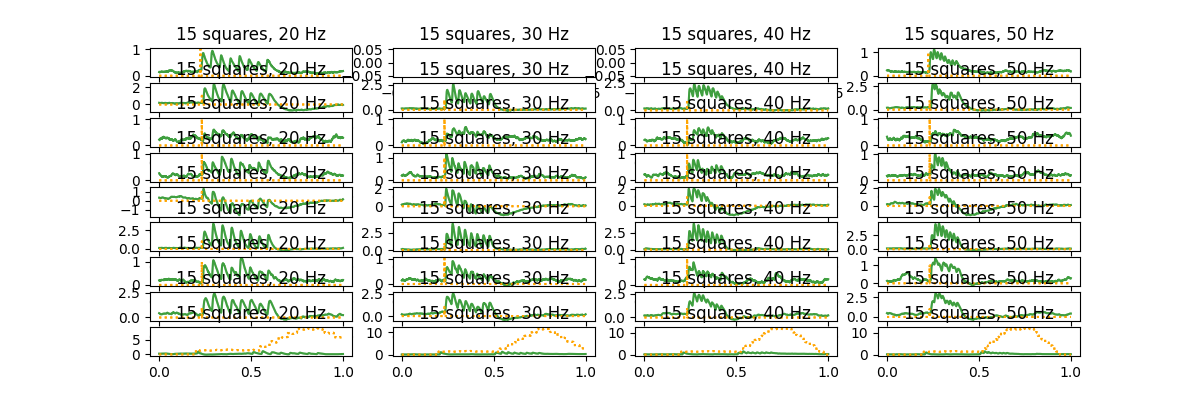

In [18]:
cells = data2['cellID'].unique()
fig, ax = plt.subplots(len(cells),4, figsize=(12,4))
for k,c in enumerate(cells):
    for i,s in enumerate([5,15]):
        for j,f in enumerate([20,30,40,50]):
            df_temp = data2[ (data2['cellID']==c) & (data2['condition']=='Control') & (data2['numSq']==5) & (data2['stimFreq']==f) ]
            obs = df_temp.iloc[:,11:20011].mean()
            exp = df_temp.iloc[:,20011:].mean()
            ax[k,j].plot(np.linspace(0,1,20000), obs, 'g', alpha=0.5, label='observed')
            ax[k,j].plot(np.linspace(0,1,20000), exp, linestyle=':',color='orange', label='expected')
            ax[k,j].set_title(f'{s} squares, {f} Hz')


In [ ]:
plt.close('all')
fig, ax = plt.subplots(len(screened_vccells),2, figsize=(10,60), sharex=True,layout='tight')

for j, neuron in enumerate(screened_vccells):
    for k, sq in enumerate([5,15]):

        data_slice = data[(data['cellID']==neuron) & (data['numSq']==sq)]

        if data_slice.shape[0]==0:
            print(neuron, sq)
            continue
        
        color = {-70:'blue', 0:'orange'}
        time  = np.linspace(0., 1.0, 20000)
        for i, row in data_slice.iterrows():
            cell = row[49:20049]
            ttl, stim, field = row[20049:40049],row[40049:60049],row[60049:80049]
            clampPot = row['clampPotential']
            # print(i, clampPot, color[clampPot])
            if np.max(-1*cell)<200:
                ax[j, k].plot(time, cell, linewidth=1, alpha=0.2, color=color[clampPot])

        ax[j, k].plot(time, 500*data_slice[data_slice['clampPotential']==-70].iloc[:,20049:40049].mean(axis=0), linewidth=1, color='green')
        ax[j, k].plot(time, 500*data_slice[data_slice['clampPotential']==-70].iloc[:,40049:60049].mean(axis=0), linewidth=1, color='cyan')
        ax[j, k].plot(time, data_slice[data_slice['clampPotential']==-70].iloc[:,60049:80049].mean(axis=0), linewidth=1, color='r')
        ax[j, k].plot(time, data_slice[data_slice['clampPotential']==-70].iloc[:,49:20049].mean(axis=0), linewidth=1, color=color[-70])
        ax[j, k].plot(time, data_slice[data_slice['clampPotential']==  0].iloc[:,49:20049].mean(axis=0), linewidth=1, color=color[0])
        ax[j, k].set_title(f'Cell {neuron}, {sq} squares')
        # set xlim
        ax[j, k].set_xlim([0.15, 0.3])

# savefig
fig.savefig(Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\AnalysisFiles\Sep2023\all_VC_freqsweep.png"), dpi=300, bbox_inches='tight')

In [ ]:
def get_expected(ch0_trace, pulse_times, freq):
    si = 20000/freq
        
    try:
        fpr = ch0_trace[pulse_times[0]:pulse_times[0]+6000]
    except:
        print('executing except block')
        pulse_times = [4000]
        [pulse_times.append[x] for x in np.arange(10000,10000+8*si+1, si)]
        # print(pulse_times)
        fpr = ch0_trace[pulse_times[0]:pulse_times[0]+6000]
    expected = np.zeros((6000+len(ch0_trace)))
    for p in pulse_times:
        t1, t2 = p, p+len(fpr)
        expected[t1:t2] += fpr

    return expected

In [ ]:
# apply get_expected function on every row, replace the columns from 20049:40049 with the expected trace, remove the columns from 40049 onwards
# 1. remove columns 40049 onwards
data = data.iloc[:, :40050]

for i in range(data.shape[0]):
    print(i)
    row = data.iloc[i,:]
    cell = row[49:20049]
    pulse_times = row['pulseTimes']
    freq = row['stimFreq']
    expected = get_expected(cell, pulse_times, freq)[:20000]
    data.iloc[i, 20049:40049] = expected

# save data
data.to_hdf(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_FreqSweep_VC_long_expected.h5", key='data', mode='w')

In [ ]:
# Logic
# '''
# 1. Iterate over rows
# 2. Get pulse times
# 3. Use first pulse time to get the trace, no need to fit, just get the raw trace
# 4. Iterate over pulse times and reconstruct the expected trace by adding the first pulse response for every pulse time
# 5. get expected - observed peaks
# 6. save the value for every peak
# '''

# This is done now. DF can be directly loaded from: "C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_FreqSweep_VC_long_expected.h5"

In [ ]:
## CC dataframe
df_path = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_FreqSweep_VC_long_expected.h5")
data = pd.read_hdf(df_path)

### Raw data plotting across E-I and numSq

In [ ]:
plt.close('all')
cell_subset = screened_vccells[:5]
fig, ax = plt.subplots(len(cell_subset),2, figsize=(15,10), sharex=True,layout='tight')

for j, neuron in enumerate(cell_subset):
    for k, sq in enumerate([5,15]):

        data_slice = data[(data['cellID']==neuron) & (data['numSq']==sq)]

        if data_slice.shape[0]==0:
            print(neuron, sq)
            continue
        
        color = {-70:'blue', 0:'red'}
        colore = {-70:'cyan', 0:'orange'}
        time  = np.linspace(0., 1.0, 20000)
        for i, row in data_slice.iterrows():
            cell = row[49:20049]
            expected = row[20049:40049]
            clampPot = row['clampPotential']
            # print(i, clampPot, color[clampPot])
            # if np.max(-1*cell)<200:
            ax[j, k].plot(time, cell, linewidth=1, alpha=0.2, color=color[clampPot])
            ax[j, k].plot(time, expected, linewidth=1, alpha=0.2, color=colore[clampPot])

        ax[j, k].plot(time, data_slice[data_slice['clampPotential']==-70].iloc[:,49:20049].mean(axis=0), linewidth=1, color=color[-70])
        ax[j, k].plot(time, data_slice[data_slice['clampPotential']==-70].iloc[:,20049:40049].mean(axis=0), linewidth=1, color='green')

        ax[j, k].plot(time, data_slice[data_slice['clampPotential']==  0].iloc[:,49:20049].mean(axis=0), linewidth=1, color=color[0])
        ax[j, k].plot(time, data_slice[data_slice['clampPotential']==  0].iloc[:,49:20049].mean(axis=0), linewidth=1, color=color[0])
        ax[j, k].set_title(f'Cell {neuron}, {sq} squares')
        # set xlim
        # ax[j, k].set_xlim([0.15, 0.3])

# savefig
fig.savefig(Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\AnalysisFiles\Sep2023\all_VC_freqsweep_vs_expected.png"), dpi=300, bbox_inches='tight')

### Upi's FitPSC to all the traces
fits = fit_PSC.main(time[0,:20000],signalE[0,:20000], 20, show_plots=True, fig='', ax='')
fits[2][0].plot(time[0,:20000],signalE[0,:20000], 'g', alpha=0.5, label='recording')

In [ ]:
Fs=2e4
importlib.reload(utils)
def fit_alpha(trace, init_conditions=[200,0.1,0.2], show_plot=False):
    t                   = np.linspace(0, len(trace)/2e4, len(trace))  # seconds at Fs sampling
    popt, _             = curve_fit(utils.delayed_alpha_function, t, trace, p0=(init_conditions))  # p0 are initial guesses A=0.5 mV, tau=50ms,delta=5ms
    A, tau, delta       = popt

    # fitted response
    T                   = np.linspace(0, 0.4, int(0.4 * Fs))  # seconds at Fs sampling
    fit_data            = utils.delayed_alpha_function(T, *popt)

    if show_plot:
        plt.figure()
        plt.plot(t, trace, 'b', label='data')
        plt.plot(T, fit_data, 'r:', label='fit')

    return fit_data

In [ ]:
ephys_data = data_slice.iloc[0,49:]
sweep1 = ephys_data[:10000]
fit_data = fit_alpha(sweep1, init_conditions=[200,0.1,0.2], show_plot=True)

In [ ]:
importlib.reload(utils)
ephys_data = data_slice.iloc[5,49:]
ch0 = ephys_data[:10000]
ch2 = ephys_data[40000:50000]

plt.figure()
plt.plot(np.linspace(0,0.5,10000), ch0)
plt.plot(np.linspace(0,0.5,10000), 100*ch2)
delay, value_at_delay, responseSign, response, peaks, zcs, pspstart = utils.PSP_start_time(sweep1, clamp='VC', EorI='I')
plt.plot(np.linspace(0,0.5,10000), 100*responseSign)
plt.plot(np.linspace(0,0.5,10000), 15*response)
plt.xlim([0.19, 0.24])

In [ ]:
def alpha_synapse(t,gmax,tau):
    a = 1/tau
    y = gmax*(a*t)*np.exp(1-a*t)
    return y

def dual_alpha(t, gmax1, tau1, gmax2, tau2):
    y = alpha_synapse(t, gmax1, tau1) + alpha_synapse(t, gmax2, tau2)
    return y

In [ ]:
response_start = 0.2+pspstart
trace = ch0[1+int(Fs*response_start):]

t                   = np.linspace(0, 0.3, len(trace))  # seconds at Fs sampling
popt_single, _      = curve_fit(alpha_synapse, t, trace)  # p0 are initial guesses A=0.5 mV, tau=50ms,delta=5ms
popt_dual, _        = curve_fit(dual_alpha, t, trace)  # p0 are initial guesses A=0.5 mV, tau=50ms,delta=5ms
# A, tau      = popt_dual

# fitted response
T                   = np.linspace(0, 0.5, int(0.5 * Fs))  # seconds at Fs sampling
fit_data_single     = alpha_synapse(T, *popt_single)
fit_data_dual       = dual_alpha(T, *popt_dual)

plt.figure()
plt.plot(t, trace, 'b', label='data')
plt.plot(T, fit_data_single, 'r:', label='fit_single_alpha')
plt.plot(T, fit_data_dual, 'g:', label='fit_dual_alpha')
plt.legend()
